# 1. Setup

## 1.1 Import Dependencies

In [1]:
import os
import uuid
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
#functional api (sıralı değil daha çok parçalı)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.2 Set GPU Growth

In [3]:
#kaynak sızıntısını engeller
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

## 1.3 Create Folder Structures

In [4]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [5]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [7]:
#uncompress tgz
!tar -xf lfw.tgz

In [17]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [6]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    reshape_frame = frame[100:350, 100:350]
    
    cv2.imshow('reshape_frame', reshape_frame)
    
    #collect anchor and positive
    #if cv2.waitKey(1) & 0XFF == ord('a'):
    #    rnd = str(random.randint(1000000, 10000000))+'.jpg'

    #    if rnd not in os.listdir(ANC_PATH):
    #        cv2.imwrite(os.path.join(ANC_PATH, rnd), reshape_frame)
            
    #if cv2.waitKey(1) & 0XFF == ord('p'):
    #    rnd = str(random.randint(10000000, 100000000))+'.jpg'

    #    if rnd not in os.listdir(POS_PATH):
    #        cv2.imwrite(os.path.join(POS_PATH, rnd), reshape_frame)
            
    #collect anchor images
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, reshape_frame)
    
    # collect positive images
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, reshape_frame)        
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

# 3. Load and Preprocess Image

## 3.1 Get Image Directories

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [6]:
pos_test = positive.as_numpy_iterator()
pos_test.next()

b'data\\positive\\b6b4a093-5110-11ec-9ecf-54e1ad8c1dfd.jpg'

## 3.2 Preprocessing Resize and Scale

In [7]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [ ]:
plt.imshow(preprocess(pos_test.next()))

## 3.3 Create Labelled Dataset

In [9]:
# anchor, positive => 1,1,1,1
# anchor, negative => 0,0,0,0

In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))))) 
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor))))) 
data = positives.concatenate(negatives)

In [11]:
data_test = data.as_numpy_iterator()

In [12]:
data_test.next()

(b'data\\anchor\\634d81f1-5110-11ec-9b2d-54e1ad8c1dfd.jpg',
 b'data\\positive\\b54ec1e1-5110-11ec-a7c9-54e1ad8c1dfd.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [13]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [14]:
preprocess_twin(*data_test.next())#dynamic arg

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.5007353 , 0.5007353 , 0.5007353 ],
         [0.5004902 , 0.5004902 , 0.4985294 ],
         [0.49240196, 0.49240196, 0.48455882],
         ...,
         [0.4090686 , 0.36985293, 0.36593136],
         [0.4154412 , 0.3762255 , 0.36936274],
         [0.41936275, 0.38014707, 0.37230393]],
 
        [[0.48357844, 0.49142158, 0.4875    ],
         [0.49779412, 0.5036765 , 0.4987745 ],
         [0.50808823, 0.50808823, 0.5002451 ],
         ...,
         [0.50784314, 0.46764705, 0.4598039 ],
         [0.44632354, 0.40612745, 0.39632353],
         [0.4715686 , 0.42843136, 0.41862744]],
 
        [[0.4610294 , 0.46887255, 0.46495098],
         [0.4745098 , 0.48039216, 0.47549018],
         [0.47867647, 0.47867647, 0.47083333],
         ...,
         [0.5107843 , 0.46764705, 0.45343137],
         [0.48039216, 0.4372549 , 0.42156863],
         [0.49632353, 0.44436276, 0.43161765]],
 
        ...,
 
        [[0.74828434, 0.76691175

In [15]:
#dataloader pipeline
data = data.map(preprocess_twin)#tek tek hepsine uygular
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [16]:
data_test = data.as_numpy_iterator()

In [17]:
data_test.next()

(array([[[0.4852941 , 0.4852941 , 0.4852941 ],
         [0.49019608, 0.48921567, 0.4872549 ],
         [0.49926472, 0.49534315, 0.48161766],
         ...,
         [0.43137255, 0.38431373, 0.38431373],
         [0.42941177, 0.38382354, 0.38308823],
         [0.422549  , 0.38333333, 0.37941176]],
 
        [[0.4757353 , 0.4776961 , 0.4747549 ],
         [0.48431373, 0.48455882, 0.4759804 ],
         [0.48872548, 0.4875    , 0.47230393],
         ...,
         [0.47892156, 0.42205882, 0.41911766],
         [0.45588234, 0.3990196 , 0.39607844],
         [0.45147058, 0.3973039 , 0.39338234]],
 
        [[0.46666667, 0.4745098 , 0.4627451 ],
         [0.46078432, 0.46617648, 0.45318627],
         [0.45759803, 0.4615196 , 0.44191176],
         ...,
         [0.5205882 , 0.46078432, 0.45196077],
         [0.4982843 , 0.4384804 , 0.42965686],
         [0.49215686, 0.43235293, 0.42352942]],
 
        ...,
 
        [[0.2247549 , 0.21176471, 0.20759805],
         [0.31887254, 0.30612746, 0.29534

In [18]:
#training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)#sonraki grubu önceden işler

In [19]:
#test partition
test_data = data.skip(round(len(data)*.7))#sonraki 30 u geçer
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)#sonraki grubu önceden işler

# 4. Model Engineering

## 4.1 Build Embeding Layer

In [20]:
def make_embedding():
    inp = Input(shape = (100, 100, 3), name = 'input_image')
    
    c1 = Conv2D(64, (10, 10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding = 'same')(c1)
    
    c2 = Conv2D(128, (7, 7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding = 'same')(c2)
    
    c3 = Conv2D(128, (4, 4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)
    
    c4 = Conv2D(256, (4, 4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embeding')

In [21]:
embedding = make_embedding()

In [22]:
embedding.summary()

Model: "embeding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0  

## 4.2 Build Distance Layer

In [23]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [24]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [25]:
def make_siamese_model():
    
    #anchor and valid input
    input_image = Input(name = 'input_img', shape = (100,100,3))
    validation_image = Input(name = 'validation_img', shape = (100,100,3))
    
    #anchor and neg or pos
    embedding = make_embedding()
    inp_embedding = embedding(input_image)
    val_embedding  = embedding(validation_image)
    
    #siamese layer
    siamese_layer = L1Dist(name = 'distance')
    distances = siamese_layer(inp_embedding, val_embedding)
    
    #classifier layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs = [input_image, validation_image], outputs = classifier, name ='SiameseNetwork')

In [26]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embeding (Functional)           (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embeding[0][0]      

# 5. Training

## 5.1 Setup Loss and Optimizer

In [27]:
binary_crossentropy = tf.losses.BinaryCrossentropy()

In [28]:
optimizer = tf.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [29]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [30]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        #get anchor and positive / negative image
        X = batch[:2]
        #get label
        y = batch[2]
        
        #forward pass
        yhat = siamese_model(X,training = True)
        #calculate loss
        loss = binary_crossentropy(y, yhat)
        
    #calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    #calculate updated weights and apply
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables)) 

    return loss

## 5.4 Build Training Loop

In [31]:
def train(data, epochs):
    for epoch in range(1, epochs+1):
        print(f'\n Epochs {epoch}/{epochs}')
        progbar = tf.keras.utils.Progbar(len(data))
        #progbar = tf.keras.utils.Progbar(len(data), stateful_metrics=['loss'])
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            
            progbar.update(idx+1)
            #progbar.update(idx+1, values = loss.numpy())
        
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

## 5.5 Train the Model

In [84]:
with tf.device('/GPU:1'):
    train(train_data, 50)


 Epochs 1/50
27/27 [==============================] - 25s 935ms/step

 Epochs 2/50
27/27 [==============================] - 25s 933ms/step

 Epochs 3/50
27/27 [==============================] - 25s 955ms/step

 Epochs 4/50
27/27 [==============================] - 26s 973ms/step

 Epochs 5/50
27/27 [==============================] - 26s 992ms/step

 Epochs 6/50
27/27 [==============================] - 26s 1s/step

 Epochs 7/50
27/27 [==============================] - 27s 1s/step

 Epochs 8/50
27/27 [==============================] - 26s 1s/step

 Epochs 9/50
27/27 [==============================] - 27s 1s/step

 Epochs 10/50
27/27 [==============================] - 27s 1s/step

 Epochs 11/50
27/27 [==============================] - 26s 998ms/step

 Epochs 12/50
27/27 [==============================] - 27s 1s/step

 Epochs 13/50
27/27 [==============================] - 27s 1s/step

 Epochs 14/50
27/27 [==============================] - 26s 1s/step

 Epochs 15/50
27/27 [=================

# 6. Evaluate Model

## 6.1 Make Predictions

In [115]:
from tensorflow.keras.metrics import Recall, Precision

test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [116]:
test_input.shape

(16, 100, 100, 3)

In [117]:
y_pred = siamese_model.predict([test_input, test_val])
y_pred

array([[9.9948394e-01],
       [9.9993694e-01],
       [1.4455574e-07],
       [3.2986257e-08],
       [6.5542323e-09],
       [9.9922359e-01],
       [9.9999976e-01],
       [7.2687105e-09],
       [9.9999821e-01],
       [2.6135052e-07],
       [1.0000000e+00],
       [1.3169476e-06],
       [1.0049798e-06],
       [7.5656041e-09],
       [5.0032991e-08],
       [1.4765882e-05]], dtype=float32)

In [118]:
[1 if prediction > 0.5 else 0 for prediction in y_pred]

[1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0]

In [119]:
y_true

array([1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

## 6.2 Calculate Metrics

In [120]:
recall = Recall()
recall.update_state(y_true, y_pred)
recall.result().numpy()

1.0

In [121]:
precision = Precision()
precision.update_state(y_true, y_pred)
precision.result().numpy()

1.0

## 6.3 Viz Results

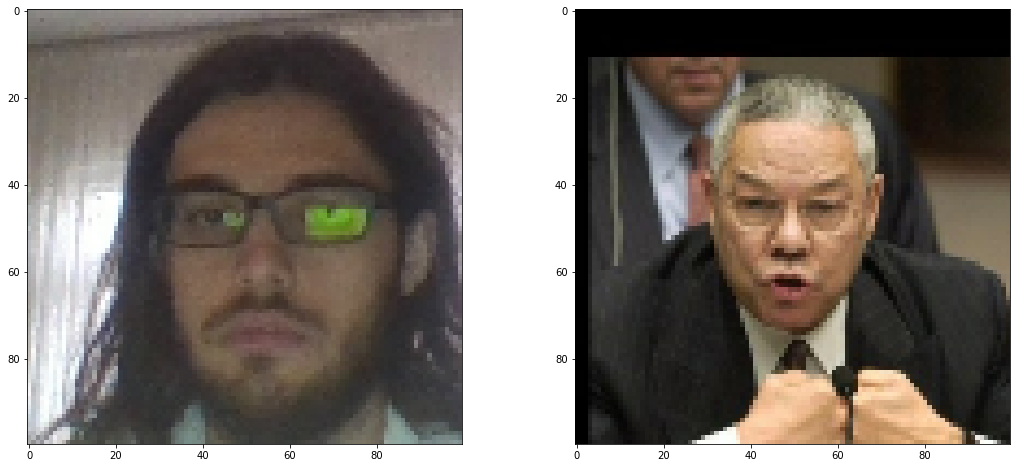

In [125]:
plt.figure(figsize = (18,8))
plt.subplot(1,2,1)
plt.imshow(test_input[2])
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# 7. Save Model

In [126]:
siamese_model.save('siamesemodel.h5')

In [32]:
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})#l1 custom olduğundan yüklememiz lazım

In [33]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embeding (Functional)           (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embeding[0][0]      

# 8. Real Time Test

In [ ]:
#buna ek yüz bulup onu sorgulasın

# 8.1 Verification Function

In [69]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_image = preprocess(os.path.join('app','application_data', 'input_image', 'input_image.jpg'))
        valid_image = preprocess(os.path.join('app','application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_image, valid_image], axis = 1)))
        results.append(result)
        
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    print(verification, detection)
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [91]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    reshape_frame = frame[100:350, 100:350]
    
    
    cv2.imshow('frame', reshape_frame)
    
    if cv2.waitKey(10) & 0xFF == ord('e'):
        cv2.imwrite(os.path.join('app','application_data', 'input_image', 'input_image.jpg'), reshape_frame)
        results, verified = verify(model, 0.9, 0.8)
        print(verified)
    
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

0.76 38
False
0.74 37
False
0.64 32
False
0.74 37
False
0.76 38
False
1.0 50
True
0.98 49
True
0.8 40
False
0.82 41
False
0.72 36
False
0.8 40
False


In [75]:
cap.release()
cv2.destroyAllWindows()